# Hymba Ablation Study - Tiny Shakespeare

## 목표
다양한 아키텍처 구성의 성능을 비교하여 각 컴포넌트의 기여도를 분석합니다.

### 테스트 구성
1. **Mamba-only**: SSM 기반 시퀀스 모델링
2. **Transformer-only**: 표준 어텐션 기반
3. **Hybrid (Hymba)**: Attention + Mamba 혼합
   - Global Attention: 첫/중간/마지막 레이어
   - Local Attention (SWA): 나머지 레이어
   - Meta Tokens: 128개
   - KV-Cache 공유

### 평가 메트릭
- 학습 Loss & Perplexity
- 검증 Loss & Perplexity
- 학습 속도 (tokens/sec)
- 추론 속도 (tokens/sec)
- KV-Cache 메모리 절감
- 생성 품질

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

# Warning 제거
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm

# 모듈 리로드 (코드 변경사항 반영)
import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import (
    Hymba, HymbaConfig, ArchType, AttentionType
)

# 데이터 로딩
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFKC, Lowercase, Sequence as NormSeq
from torch.utils.data import DataLoader, TensorDataset, random_split

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 디바이스
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"디바이스: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"BF16 지원: {torch.cuda.is_bf16_supported()}")

디바이스: cuda
GPU: NVIDIA A100 80GB PCIe
BF16 지원: True


## 1. 데이터 준비

In [2]:
# Tiny Shakespeare 로드
print("데이터 로딩 중...")
ds = load_dataset("karpathy/tiny_shakespeare")
text = "\n\n".join(ds["train"]["text"])

print(f"전체 텍스트 길이: {len(text):,} 문자")
print(f"\n샘플:\n{text[:500]}...")

데이터 로딩 중...
전체 텍스트 길이: 1,003,854 문자

샘플:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor...


In [3]:
# 토크나이저 학습
print("\n토크나이저 학습 중...")
vocab_size = 4000

tk = Tokenizer(Unigram())
tk.normalizer = NormSeq([NFKC(), Lowercase()])
tk.pre_tokenizer = Whitespace()
trainer = UnigramTrainer(vocab_size=vocab_size, special_tokens=["<|unk|>"], unk_token="<|unk|>")
tk.train_from_iterator([text], trainer=trainer)

class TokenizerWrap:
    def __init__(self, tk):
        self.tk = tk
    def encode(self, s):
        return self.tk.encode(s).ids
    def decode(self, ids):
        return self.tk.decode(ids)
    @property
    def vocab_size(self):
        return self.tk.get_vocab_size()

tokenizer = TokenizerWrap(tk)
print(f"어휘 크기: {tokenizer.vocab_size}")


토크나이저 학습 중...


어휘 크기: 4000


In [4]:
# 데이터로더 생성
def make_dataset(tok, text, seq_len=256):
    ids = np.array(tok.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n = (len(y) // seq_len) * seq_len
    X = torch.tensor(x[:n].reshape(-1, seq_len))
    Y = torch.tensor(y[:n].reshape(-1, seq_len))
    return TensorDataset(X, Y)

seq_len = 256
batch_size = 16

ds_full = make_dataset(tokenizer, text, seq_len)
tr_len = int(0.9 * len(ds_full))
va_len = len(ds_full) - tr_len
train_ds, val_ds = random_split(ds_full, [tr_len, va_len])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"\n학습 배치: {len(train_dl)}")
print(f"검증 배치: {len(val_dl)}")


학습 배치: 64
검증 배치: 8


## 2. 모델 구성 정의

In [5]:
# 기본 하이퍼파라미터 (15 레이어로 증가)
base_config = {
    "vocab_size": vocab_size,
    "d_model": 512,  # 모델 크기 증가
    "n_layers": 15,  # 15 레이어
    "n_heads": 8,
    "n_kv_heads": 4,
    "swa_window": 128,
    "dropout": 0.1,
    "seq_len": seq_len,
}

# 테스트 구성들
configs = {
    "Mamba-only": HymbaConfig(
        **base_config,
        arch_type=ArchType.MAMBA_ONLY,
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    "Transformer-only (Global)": HymbaConfig(
        **base_config,
        arch_type=ArchType.TRANSFORMER_ONLY,
        global_attn_indices=list(range(15)),  # 모든 레이어가 Global
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    "Transformer-only (Local)": HymbaConfig(
        **base_config,
        arch_type=ArchType.TRANSFORMER_ONLY,
        global_attn_indices=[],  # 모든 레이어가 Local
        use_meta_tokens=False,
        use_kv_sharing=True,
    ),
    "Hybrid (50/50)": HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        attn_ratio=0.5,
        global_attn_indices=None,  # auto: first/middle/last
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
    "Hybrid (Paper Setting)": HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        attn_ratio=0.5,  # 50% Attention, 50% Mamba
        global_attn_indices=[0, 7, 14],  # 첫/중간/마지막 레이어 (3/15 = 20.0% Global)
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
}

print("=" * 100)
print("Test Configurations (15 layers, Enhanced Training)")
print("=" * 100)

for name, cfg in configs.items():
    print(f"\n{'='*100}")
    print(f"[{name}]")
    print(f"{'='*100}")
    print(f"  Architecture Type: {cfg.arch_type.value.upper()}")
    print(f"  Total Layers: {cfg.n_layers}")
    print(f"  d_model: {cfg.d_model}")
    print(f"  n_heads: {cfg.n_heads} (n_kv_heads: {cfg.n_kv_heads})")
    print(f"  Total Parameters: ~{(cfg.d_model**2 * cfg.n_layers * 4) / 1e6:.1f}M (estimated)")
    
    if cfg.arch_type == ArchType.HYBRID:
        attn_types = cfg.get_attention_types()
        global_idx = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
        local_idx = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL]
        
        # 구체적인 비율 계산
        num_attn_layers = len([i for i, t in enumerate(attn_types) if t in [AttentionType.GLOBAL, AttentionType.LOCAL]])
        num_mamba_layers = cfg.n_layers - num_attn_layers
        num_global = len(global_idx)
        num_local = len(local_idx)
        
        print(f"\n  Layer Composition:")
        print(f"    - Attention Layers: {num_attn_layers}/{cfg.n_layers} ({num_attn_layers/cfg.n_layers*100:.1f}%)")
        print(f"      ├─ Global Attention: {num_global}/{num_attn_layers} layers ({num_global/cfg.n_layers*100:.1f}% of total)")
        print(f"      │  Layers: {global_idx}")
        print(f"      │  Complexity: O(n²) per layer")
        print(f"      └─ Local Attention (SWA): {num_local}/{num_attn_layers} layers ({num_local/cfg.n_layers*100:.1f}% of total)")
        print(f"         Layers: {local_idx}")
        print(f"         Window Size: {cfg.swa_window}")
        print(f"         Complexity: O(n·w) per layer, w={cfg.swa_window}")
        print(f"    - Mamba Layers: {num_mamba_layers}/{cfg.n_layers} ({num_mamba_layers/cfg.n_layers*100:.1f}%)")
        print(f"      Complexity: O(n) per layer (linear)")
        
        print(f"\n  Special Features:")
        print(f"    - Meta Tokens: {cfg.num_meta_tokens if cfg.use_meta_tokens else 0} learnable global tokens")
        print(f"    - KV Cache Sharing: {'Enabled' if cfg.use_kv_sharing else 'Disabled'}")
        if cfg.use_kv_sharing:
            print(f"      Expected reduction: ~{num_attn_layers / max(1, (num_global + num_local//2)):.2f}x")
    elif cfg.arch_type == ArchType.TRANSFORMER_ONLY:
        if cfg.global_attn_indices == list(range(cfg.n_layers)):
            print(f"  All {cfg.n_layers} layers use Global Attention (100%)")
            print(f"  Complexity: O(n²) × {cfg.n_layers} layers")
        elif not cfg.global_attn_indices:
            print(f"  All {cfg.n_layers} layers use Local Attention/SWA (100%)")
            print(f"  Sliding Window Size: {cfg.swa_window}")
            print(f"  Complexity: O(n·{cfg.swa_window}) × {cfg.n_layers} layers")
        print(f"  KV Cache Sharing: {'Enabled' if cfg.use_kv_sharing else 'Disabled'}")
    else:  # MAMBA_ONLY
        print(f"  All {cfg.n_layers} layers use Mamba SSM (100%)")
        print(f"  Complexity: O(n) × {cfg.n_layers} layers (linear)")

print(f"\n{'='*100}")
print(f"Training Configuration:")
print(f"  - Epochs: 30")
print(f"  - Scheduler: Cosine Annealing with Linear Warmup")
print(f"  - Mixed Precision: BF16 AMP (Automatic Mixed Precision)")
print(f"  - Gradient Clipping: 1.0")
print(f"  - Training Stages: Pretraining → ORPO (Reinforcement Learning)")
print(f"{'='*100}")

Test Configurations (15 layers, Enhanced Training)

[Mamba-only]
  Architecture Type: MAMBA
  Total Layers: 15
  d_model: 512
  n_heads: 8 (n_kv_heads: 4)
  Total Parameters: ~15.7M (estimated)
  All 15 layers use Mamba SSM (100%)
  Complexity: O(n) × 15 layers (linear)

[Transformer-only (Global)]
  Architecture Type: TRANSFORMER
  Total Layers: 15
  d_model: 512
  n_heads: 8 (n_kv_heads: 4)
  Total Parameters: ~15.7M (estimated)
  All 15 layers use Global Attention (100%)
  Complexity: O(n²) × 15 layers
  KV Cache Sharing: Disabled

[Transformer-only (Local)]
  Architecture Type: TRANSFORMER
  Total Layers: 15
  d_model: 512
  n_heads: 8 (n_kv_heads: 4)
  Total Parameters: ~15.7M (estimated)
  All 15 layers use Local Attention/SWA (100%)
  Sliding Window Size: 128
  Complexity: O(n·128) × 15 layers
  KV Cache Sharing: Enabled

[Hybrid (50/50)]
  Architecture Type: HYBRID
  Total Layers: 15
  d_model: 512
  n_heads: 8 (n_kv_heads: 4)
  Total Parameters: ~15.7M (estimated)

  Layer Com

## 3. 학습 함수

In [6]:
def train_model_enhanced(model, train_dl, val_dl, epochs=30, lr=3e-4, warmup_steps=200, 
                         eval_interval=32, device='cuda', stage_name="Pretraining"):
    """
    개선된 모델 학습 함수
    - Cosine Annealing with Linear Warmup
    - BF16 Mixed Precision Training
    - Gradient Clipping
    - Detailed logging
    
    Args:
        model: Hymba 모델
        train_dl: 학습 데이터로더
        val_dl: 검증 데이터로더
        epochs: 학습 에포크 수
        lr: 최대 learning rate
        warmup_steps: Warmup 스텝 수
        eval_interval: Validation 수행 간격
        device: 학습 디바이스
        stage_name: 학습 단계 이름 (Pretraining/ORPO)
    
    Returns:
        dict: 학습 결과 및 history
    """
    model = model.to(device).train()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.95), 
        weight_decay=0.1,
        eps=1e-8
    )
    
    total_steps = epochs * len(train_dl)
    
    # Cosine Annealing with Linear Warmup
    def lr_schedule(step):
        if step < warmup_steps:
            # Linear warmup
            return step / warmup_steps
        else:
            # Cosine annealing
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    
    # BF16 Mixed Precision
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    if use_amp:
        scaler = torch.amp.GradScaler('cuda')
        print(f"  Using BF16 AMP for {stage_name}")
    else:
        scaler = None
        print(f"  Using FP32 for {stage_name}")
    
    # History tracking
    history = {
        "train_loss": [], 
        "val_loss": [], 
        "train_ppl": [],
        "val_ppl": [],
        "lr": [],
        "step": [],
        "epoch": []
    }
    
    step = 0
    t0 = time.time()
    best_val_loss = float('inf')
    best_epoch = 0
    
    print(f"\\n{'='*80}")
    print(f"Starting {stage_name}")
    print(f"{'='*80}")
    print(f"  Total Steps: {total_steps}")
    print(f"  Warmup Steps: {warmup_steps}")
    print(f"  Max LR: {lr}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {train_dl.batch_size}")
    print(f"{'='*80}\\n")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_tokens = 0
        
        pbar = tqdm(train_dl, desc=f"[{stage_name}] Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            # Forward & Backward
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    loss = out["loss"]
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                loss = out["loss"]
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            
            epoch_loss += loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            # Validation
            if step % eval_interval == 0 or step == total_steps:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        val_loss += vout["loss"].item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                current_lr = scheduler.get_last_lr()[0]
                
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["train_ppl"].append(np.exp(train_loss))
                history["val_ppl"].append(np.exp(val_loss))
                history["lr"].append(current_lr)
                history["step"].append(step)
                history["epoch"].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                
                pbar.set_postfix({
                    "loss": f"{train_loss:.3f}",
                    "val": f"{val_loss:.3f}",
                    "ppl": f"{np.exp(val_loss):.2f}",
                    "lr": f"{current_lr:.2e}",
                    "grad": f"{grad_norm:.2f}"
                })
                
                model.train()
    
    elapsed = time.time() - t0
    total_tokens = epochs * len(train_dl) * train_dl.batch_size * seq_len
    tps = int(total_tokens / elapsed)
    
    print(f"\\n{'='*80}")
    print(f"{stage_name} Completed")
    print(f"{'='*80}")
    print(f"  Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Training Time: {elapsed/60:.1f} min")
    print(f"  Throughput: {tps:,} tokens/sec")
    print(f"{'='*80}\\n")
    
    return {
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "train_ppl": history["train_ppl"][-1],
        "val_ppl": history["val_ppl"][-1],
        "best_val_ppl": np.exp(best_val_loss),
        "train_tps": tps,
        "time_min": elapsed / 60,
        "history": history,
    }


def train_orpo(model, train_dl, val_dl, epochs=10, lr=1e-4, warmup_steps=100, 
               beta=0.1, eval_interval=32, device='cuda'):
    """
    ORPO (Odds Ratio Preference Optimization) 학습
    
    ORPO는 SFT와 preference learning을 결합한 알고리즘으로:
    1. 선호하는 응답에 대한 likelihood 최대화
    2. 비선호 응답에 대한 likelihood 최소화
    3. Odds ratio를 사용한 안정적인 최적화
    
    Args:
        model: Hymba 모델
        train_dl: 학습 데이터로더
        val_dl: 검증 데이터로더
        epochs: 학습 에포크 수
        lr: Learning rate (pretraining보다 낮게)
        warmup_steps: Warmup 스텝 수
        beta: ORPO loss의 강도 조절 파라미터
        eval_interval: Validation 수행 간격
        device: 학습 디바이스
    
    Returns:
        dict: 학습 결과 및 history
    """
    model = model.to(device).train()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.95), 
        weight_decay=0.01  # ORPO에서는 낮은 weight decay
    )
    
    total_steps = epochs * len(train_dl)
    
    def lr_schedule(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    history = {
        "train_loss": [],
        "orpo_loss": [],
        "sft_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
        "lr": [],
        "step": [],
        "epoch": []
    }
    
    step = 0
    t0 = time.time()
    best_val_loss = float('inf')
    
    print(f"\\n{'='*80}")
    print(f"Starting ORPO Training")
    print(f"{'='*80}")
    print(f"  Beta (preference strength): {beta}")
    print(f"  LR: {lr} (lower than pretraining)")
    print(f"  Epochs: {epochs}")
    print(f"{'='*80}\\n")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_orpo_loss = 0.0
        epoch_sft_loss = 0.0
        epoch_tokens = 0
        
        pbar = tqdm(train_dl, desc=f"[ORPO] Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            # ORPO는 preference pair가 필요하지만, 여기서는 단순화를 위해
            # positive example로만 학습 (실제로는 chosen/rejected pair 필요)
            
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    logits = out["logits"]
                    
                    # SFT Loss (standard cross-entropy)
                    sft_loss = F.cross_entropy(
                        logits.reshape(-1, logits.size(-1)),
                        yb.reshape(-1),
                        ignore_index=-100
                    )
                    
                    # ORPO Loss (simplified - 실제로는 chosen/rejected 비교 필요)
                    # 여기서는 높은 confidence로 정답을 예측하도록 유도
                    log_probs = F.log_softmax(logits, dim=-1)
                    target_log_probs = torch.gather(
                        log_probs, 2, yb.unsqueeze(-1)
                    ).squeeze(-1)
                    
                    # Odds ratio penalty (간소화 버전)
                    orpo_penalty = -torch.mean(target_log_probs)
                    
                    # Total loss
                    loss = sft_loss + beta * orpo_penalty
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                logits = out["logits"]
                
                sft_loss = F.cross_entropy(
                    logits.reshape(-1, logits.size(-1)),
                    yb.reshape(-1),
                    ignore_index=-100
                )
                
                log_probs = F.log_softmax(logits, dim=-1)
                target_log_probs = torch.gather(
                    log_probs, 2, yb.unsqueeze(-1)
                ).squeeze(-1)
                orpo_penalty = -torch.mean(target_log_probs)
                
                loss = sft_loss + beta * orpo_penalty
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            
            epoch_loss += loss.item() * xb.numel()
            epoch_orpo_loss += orpo_penalty.item() * xb.numel()
            epoch_sft_loss += sft_loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            # Validation
            if step % eval_interval == 0 or step == total_steps:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        val_loss += vout["loss"].item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                orpo_loss = epoch_orpo_loss / epoch_tokens
                sft_loss = epoch_sft_loss / epoch_tokens
                current_lr = scheduler.get_last_lr()[0]
                
                history["train_loss"].append(train_loss)
                history["orpo_loss"].append(orpo_loss)
                history["sft_loss"].append(sft_loss)
                history["val_loss"].append(val_loss)
                history["train_ppl"].append(np.exp(sft_loss))
                history["val_ppl"].append(np.exp(val_loss))
                history["lr"].append(current_lr)
                history["step"].append(step)
                history["epoch"].append(epoch + 1)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                
                pbar.set_postfix({
                    "sft": f"{sft_loss:.3f}",
                    "orpo": f"{orpo_loss:.3f}",
                    "val": f"{val_loss:.3f}",
                    "ppl": f"{np.exp(val_loss):.2f}"
                })
                
                model.train()
    
    elapsed = time.time() - t0
    total_tokens = epochs * len(train_dl) * train_dl.batch_size * seq_len
    tps = int(total_tokens / elapsed)
    
    return {
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "best_val_loss": best_val_loss,
        "sft_loss": history["sft_loss"][-1],
        "orpo_loss": history["orpo_loss"][-1],
        "train_ppl": history["train_ppl"][-1],
        "val_ppl": history["val_ppl"][-1],
        "best_val_ppl": np.exp(best_val_loss),
        "train_tps": tps,
        "time_min": elapsed / 60,
        "history": history,
    }

## 4. 추론 속도 벤치마크

In [7]:
def benchmark_inference(model, tokenizer, prompt="ROMEO:", max_tokens=100, n_runs=3, device='cuda'):
    """
    추론 속도 측정
    """
    model = model.to(device).eval()
    prompt_tokens = tokenizer.encode(prompt)
    prompt_tensor = torch.tensor([prompt_tokens]).to(device)
    
    times = []
    for _ in range(n_runs):
        if device == 'cuda':
            torch.cuda.synchronize()
        
        t0 = time.time()
        with torch.no_grad():
            _ = model.generate(prompt_tensor, max_new_tokens=max_tokens, temperature=1.0)
        
        if device == 'cuda':
            torch.cuda.synchronize()
        
        elapsed = time.time() - t0
        times.append(elapsed)
    
    avg_time = np.mean(times)
    tps = max_tokens / avg_time
    
    return {"time_sec": avg_time, "tokens_per_sec": tps}

## 5. 모델 학습 및 평가

In [ ]:
# 모든 구성 학습 - 2단계 학습 (Pretraining → ORPO)
results = {}

for name, cfg in configs.items():
    print(f"\n{'='*100}")
    print(f"Model: {name}")
    print(f"{'='*100}")
    
    # 모델 생성
    model = Hymba(cfg)
    params = model.count_parameters()
    print(f"Parameters: {params['total']:,}")
    
    # 아키텍처 정보
    if cfg.arch_type == ArchType.HYBRID:
        attn_info = model.get_attention_pattern_info()
        print(f"Attention Layers: {attn_info['num_global'] + attn_info['num_local']}/{cfg.n_layers}")
        print(f"Global Layers: {attn_info['global_layers']}")
        print(f"Local Layers: {attn_info['local_layers']}")
    
    # KV 공유 정보
    if cfg.arch_type != ArchType.MAMBA_ONLY:
        kv_info = model.get_kv_sharing_info()
        print(f"KV Cache Reduction: {kv_info['reduction']:.2f}x")
        print(f"Independent Caches: {kv_info['independent_caches']}/{kv_info['total_layers']}")
    
    # ========== Stage 1: Pretraining (30 epochs) ==========
    print(f"\n{'='*100}")
    print(f"STAGE 1: PRETRAINING")
    print(f"{'='*100}")
    
    pretrain_results = train_model_enhanced(
        model, train_dl, val_dl, 
        epochs=30,
        lr=3e-4,
        warmup_steps=200,
        eval_interval=32,
        device=device,
        stage_name="Pretraining"
    )
    
    # 모델 체크포인트 저장 (pretraining 완료)
    pretrain_state = {
        'model_state': model.state_dict(),
        'val_loss': pretrain_results['val_loss'],
        'val_ppl': pretrain_results['val_ppl'],
    }
    
    # ========== Stage 2: ORPO (10 epochs) ==========
    print(f"\n{'='*100}")
    print(f"STAGE 2: ORPO (Reinforcement Learning)")
    print(f"{'='*100}")
    
    orpo_results = train_orpo(
        model, train_dl, val_dl,
        epochs=10,
        lr=1e-4,  # Lower LR than pretraining
        warmup_steps=100,
        beta=0.1,  # ORPO penalty strength
        eval_interval=32,
        device=device
    )
    
    # 추론 벤치마크 (ORPO 완료 후)
    print(f"\nBenchmarking inference (after ORPO)...")
    infer_results = benchmark_inference(model, tokenizer, device=device)
    
    # 생성 샘플 (3개)
    print(f"\nGenerating samples (after ORPO)...")
    samples = []
    prompts_list = ["ROMEO:", "First Citizen:", "KING:"]
    for prompt in prompts_list:
        prompt_tokens = tokenizer.encode(prompt)
        prompt_tensor = torch.tensor([prompt_tokens]).to(device)
        with torch.no_grad():
            generated = model.generate(prompt_tensor, max_new_tokens=80, temperature=0.8, top_k=40)
        sample_text = tokenizer.decode(generated[0].cpu().tolist())
        samples.append(sample_text)
    
    # 결과 저장 (두 단계 모두 포함)
    results[name] = {
        # Pretraining results
        "pretrain_train_loss": pretrain_results['train_loss'],
        "pretrain_val_loss": pretrain_results['val_loss'],
        "pretrain_best_val_loss": pretrain_results['best_val_loss'],
        "pretrain_val_ppl": pretrain_results['val_ppl'],
        "pretrain_best_val_ppl": pretrain_results['best_val_ppl'],
        "pretrain_history": pretrain_results['history'],
        
        # ORPO results
        "orpo_train_loss": orpo_results['train_loss'],
        "orpo_val_loss": orpo_results['val_loss'],
        "orpo_best_val_loss": orpo_results['best_val_loss'],
        "orpo_val_ppl": orpo_results['val_ppl'],
        "orpo_best_val_ppl": orpo_results['best_val_ppl'],
        "orpo_sft_loss": orpo_results['sft_loss'],
        "orpo_penalty": orpo_results['orpo_loss'],
        "orpo_history": orpo_results['history'],
        
        # Final metrics
        "final_val_loss": orpo_results['val_loss'],
        "final_val_ppl": orpo_results['val_ppl'],
        "best_val_loss": min(pretrain_results['best_val_loss'], orpo_results['best_val_loss']),
        "best_val_ppl": min(pretrain_results['best_val_ppl'], orpo_results['best_val_ppl']),
        
        # Inference and other metrics
        **infer_results,
        "params": params['total'],
        "samples": samples,
        "kv_reduction": kv_info['reduction'] if cfg.arch_type != ArchType.MAMBA_ONLY else 1.0,
        "total_time_min": pretrain_results['time_min'] + orpo_results['time_min'],
    }
    
    print(f"\n{'='*100}")
    print(f"FINAL RESULTS (after both stages):")
    print(f"{'='*100}")
    print(f"\nPretraining Stage:")
    print(f"  Best Val Loss: {pretrain_results['best_val_loss']:.4f} | PPL: {pretrain_results['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {pretrain_results['val_loss']:.4f} | PPL: {pretrain_results['val_ppl']:.2f}")
    print(f"  Training Time: {pretrain_results['time_min']:.1f} min")
    
    print(f"\nORPO Stage:")
    print(f"  Best Val Loss: {orpo_results['best_val_loss']:.4f} | PPL: {orpo_results['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {orpo_results['val_loss']:.4f} | PPL: {orpo_results['val_ppl']:.2f}")
    print(f"  SFT Loss: {orpo_results['sft_loss']:.4f}")
    print(f"  ORPO Penalty: {orpo_results['orpo_loss']:.4f}")
    print(f"  Training Time: {orpo_results['time_min']:.1f} min")
    
    print(f"\nOverall:")
    print(f"  Best Val Loss (either stage): {results[name]['best_val_loss']:.4f} | PPL: {results[name]['best_val_ppl']:.2f}")
    print(f"  Final Val Loss: {results[name]['final_val_loss']:.4f} | PPL: {results[name]['final_val_ppl']:.2f}")
    print(f"  Infer Speed: {infer_results['tokens_per_sec']:.1f} tok/s")
    print(f"  Total Training Time: {results[name]['total_time_min']:.1f} min")
    
    print(f"\nSample (ROMEO, after ORPO):")
    print(f"  {samples[0][:150]}...")
    print(f"{'='*100}")


Model: Mamba-only
Parameters: 82,534,912

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining
\n================================================================================
Starting Pretraining
  Total Steps: 1920
  Warmup Steps: 200
  Max LR: 0.0003
  Epochs: 30
  Batch Size: 16
================================================================================\n


[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

\n================================================================================
Pretraining Completed
  Best Val Loss: 4.1551 (Epoch 7)
  Final Val Loss: 6.0355
  Training Time: 2.1 min
  Throughput: 63,012 tokens/sec
================================================================================\n

STAGE 2: ORPO (Reinforcement Learning)
\n================================================================================
Starting ORPO Training
  Beta (preference strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10
================================================================================\n


[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.1551 | PPL: 63.76
  Final Val Loss: 6.0355 | PPL: 418.00
  Training Time: 2.1 min

ORPO Stage:
  Best Val Loss: 6.0480 | PPL: 423.25
  Final Val Loss: 6.3408 | PPL: 567.24
  SFT Loss: 0.3747
  ORPO Penalty: 0.3747
  Training Time: 0.7 min

Overall:
  Best Val Loss (either stage): 4.1551 | PPL: 63.76
  Final Val Loss: 6.3408 | PPL: 567.24
  Infer Speed: 81.2 tok/s
  Total Training Time: 2.8 min

Sample (ROMEO, after ORPO):
  rome o : juliet : we all a live in justice , than my self same kind of good friend petruc hi b in the y are in place be rough t ry b in the s t hat h ...

Model: Transformer-only (Global)
Parameters: 68,910,592
KV Cache Reduction: 1.00x
Independent Caches: 15/15

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining
\n================================================================================
Starting Pretraining

[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

\n================================================================================
Pretraining Completed
  Best Val Loss: 4.2334 (Epoch 8)
  Final Val Loss: 5.5248
  Training Time: 2.4 min
  Throughput: 54,244 tokens/sec
================================================================================\n

STAGE 2: ORPO (Reinforcement Learning)
\n================================================================================
Starting ORPO Training
  Beta (preference strength): 0.1
  LR: 0.0001 (lower than pretraining)
  Epochs: 10
================================================================================\n


[ORPO] Epoch 1/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 2/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 3/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 4/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 5/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 6/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 7/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 8/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 9/10:   0%|          | 0/64 [00:00<?, ?it/s]

[ORPO] Epoch 10/10:   0%|          | 0/64 [00:00<?, ?it/s]


Benchmarking inference (after ORPO)...

Generating samples (after ORPO)...

FINAL RESULTS (after both stages):

Pretraining Stage:
  Best Val Loss: 4.2334 | PPL: 68.95
  Final Val Loss: 5.5248 | PPL: 250.84
  Training Time: 2.4 min

ORPO Stage:
  Best Val Loss: 5.5351 | PPL: 253.44
  Final Val Loss: 5.9108 | PPL: 369.02
  SFT Loss: 0.8982
  ORPO Penalty: 0.8982
  Training Time: 0.8 min

Overall:
  Best Val Loss (either stage): 4.2334 | PPL: 68.95
  Final Val Loss: 5.9108 | PPL: 369.02
  Infer Speed: 54.1 tok/s
  Total Training Time: 3.2 min

Sample (ROMEO, after ORPO):
  rome o : love , now it . rome o , she came : ' s dead ; she ' tis but heart ed ward . rome o g remi o , lord . mercu tio s pent : rome o ' s , she is ...

Model: Transformer-only (Local)
Parameters: 68,910,592
KV Cache Reduction: 1.88x
Independent Caches: 8/15

STAGE 1: PRETRAINING
  Using BF16 AMP for Pretraining
\n================================================================================
Starting Pretraining
 

[Pretraining] Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

W1208 16:13:10.356000 31426 torch/fx/experimental/symbolic_shapes.py:6823] [0/2] _maybe_guard_rel() was called on non-relation expression Eq(s4, 1) | Eq(s5, s4)


[Pretraining] Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

[Pretraining] Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

## 6. 결과 시각화

In [ ]:
# 결과 DataFrame (두 단계 학습 결과 포함)
df = pd.DataFrame([
    {
        "Model": name,
        "Pretrain Best PPL": r['pretrain_best_val_ppl'],
        "ORPO Best PPL": r['orpo_best_val_ppl'],
        "Final Best PPL": r['best_val_ppl'],
        "Final Val PPL": r['final_val_ppl'],
        "Infer Speed (tok/s)": r['tokens_per_sec'],
        "Params (M)": r['params'] / 1e6,
        "KV Reduction": r['kv_reduction'],
        "Total Time (min)": r['total_time_min'],
    }
    for name, r in results.items()
])

print("\n" + "="*100)
print("Final Results Summary (Two-Stage Training: Pretraining → ORPO)")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# 최고 성능 모델 분석
print("\n" + "="*100)
print("Best Models by Metric")
print("="*100)

best_overall = df.loc[df['Final Best PPL'].idxmin()]
print(f"\nBest Overall Performance (PPL): {best_overall['Model']}")
print(f"  Final Best PPL: {best_overall['Final Best PPL']:.2f}")
print(f"  Pretraining PPL: {best_overall['Pretrain Best PPL']:.2f}")
print(f"  ORPO PPL: {best_overall['ORPO Best PPL']:.2f}")

best_improvement = df.copy()
best_improvement['Improvement %'] = ((best_improvement['Pretrain Best PPL'] - best_improvement['ORPO Best PPL']) / best_improvement['Pretrain Best PPL'] * 100)
best_improver = best_improvement.loc[best_improvement['Improvement %'].idxmax()]
print(f"\nBest ORPO Improvement: {best_improver['Model']}")
print(f"  Improvement: {best_improver['Improvement %']:.2f}%")
print(f"  {best_improver['Pretrain Best PPL']:.2f} → {best_improver['ORPO Best PPL']:.2f}")

print("="*100)



Final Results Summary
                    Model  Best Val Loss  Best Val PPL  Final Val Loss  Final Val PPL  Train Speed (tok/s)  Infer Speed (tok/s)  Params (M)  KV Reduction  Training Time (min)
               Mamba-only       4.229439     68.678669        5.292254     198.791056                62260            86.092723   82.534912      1.000000             1.403488
Transformer-only (Global)       4.332892     76.164255        4.849984     127.738287                53617            55.991878   68.910592      1.000000             1.629725
 Transformer-only (Local)       2.543173     12.719967        3.378861      29.337339                16064            15.176335   68.910592      1.875000             5.439538
           Hybrid (50/50)       1.648638      5.199890        1.651141       5.212924                14812            14.494495   66.662415      1.666667             5.899134
   Hybrid (Paper Setting)       1.803768      6.072486        1.804013       6.073976                1

### Attention Pattern 분석: Pretraining vs ORPO

#### 예상되는 주요 변화 패턴:

**1. Global Attention Layers (0, 7, 14)**
- **Pretraining**: 
  - 전체 시퀀스에 걸친 균등한 분산
  - Meta token에 대한 기본적인 의존성
  - 문법적 구조에 대한 일반적인 attention
  
- **ORPO 이후**:
  - 더 선택적이고 집중된 attention pattern
  - Meta token 활용도 증가 (강화학습을 통한 최적화)
  - 중요한 문맥 단어에 대한 sharper focus

**2. Local Attention Layers (SWA)**
- **Pretraining**:
  - Sliding window 내에서 비교적 균등한 분산
  - 대각선 패턴 (causal attention)
  
- **ORPO 이후**:
  - Window 내에서 더 강한 local dependency
  - 인접 토큰에 대한 더 명확한 attention weight

**3. Meta Token의 역할 변화**
- **Pretraining**: 도메인 일반 지식 저장
- **ORPO**: Preference-aligned 표현으로 진화 (선호되는 응답 패턴 캡슐화)

**4. ORPO의 효과**
- Odds Ratio Preference Optimization은 선호하는 응답의 likelihood를 높이고 비선호 응답을 낮춤
- Attention pattern이 더 discriminative하게 변화
- 불필요한 attention을 줄이고 중요한 부분에 집중

In [ ]:
def visualize_attention_maps_stages(model, tokenizer, prompt="First Citizen: Before we proceed", 
                                     max_len=64, num_meta=64, stage_name="Training"):
    """
    Hymba 모델의 주요 레이어별 attention map 시각화
    
    Args:
        model: Hymba 모델
        tokenizer: 토크나이저
        prompt: 입력 프롬프트
        max_len: 생성할 최대 길이
        num_meta: Meta token 개수
        stage_name: 학습 단계 이름 (Pretraining/ORPO)
    
    Returns:
        dict: attention weights by layer
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 입력 준비
    prompt_tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor([prompt_tokens[:max_len]]).to(device)
    
    # Forward pass with attention weights
    with torch.no_grad():
        outputs = model(input_ids, return_attn=True)
    
    attn_weights = outputs.get('attention_weights', [])
    
    if not attn_weights:
        print(f"Warning: No attention weights available for {stage_name}")
        return None
    
    # 시각화할 레이어 선택 (Global과 Local 포함)
    cfg = model.cfg
    attn_types = cfg.get_attention_types()
    global_layers = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
    local_layers = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL]
    
    # Global 레이어 3개 + 대표 Local 레이어 2개
    viz_layers = global_layers[:3]  # [0, 7, 14]
    if len(local_layers) >= 2:
        viz_layers += [local_layers[len(local_layers)//4], local_layers[3*len(local_layers)//4]]
    
    viz_layers = sorted(viz_layers)
    
    # 시각화
    n_viz = min(len(viz_layers), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, layer_idx in enumerate(viz_layers[:6]):
        if layer_idx >= len(attn_weights):
            continue
            
        attn = attn_weights[layer_idx]  # [B, H, T, T]
        
        # 평균 attention (모든 head에 대해)
        attn_avg = attn[0].mean(dim=0).cpu().numpy()  # [T, T]
        
        ax = axes[idx]
        
        # Attention map 그리기
        im = ax.imshow(attn_avg, cmap='hot', aspect='auto', interpolation='nearest')
        
        # 레이어 정보
        layer_type = "Global" if layer_idx in global_layers else "Local (SWA)"
        ax.set_title(f'{stage_name} - Layer {layer_idx} ({layer_type})\n{attn_avg.shape[0]} tokens', 
                     fontsize=11, fontweight='bold')
        
        # Meta token 영역 표시
        if num_meta > 0 and attn_avg.shape[0] > num_meta:
            ax.axvline(num_meta - 0.5, color='cyan', linewidth=2, linestyle='--', alpha=0.7)
            ax.axhline(num_meta - 0.5, color='cyan', linewidth=2, linestyle='--', alpha=0.7)
            
            # Meta token 영역 라벨
            if idx < 3:  # 상단 행에만 라벨 표시
                ax.text(num_meta/2, -2, 'Meta', ha='center', fontsize=9, color='cyan', fontweight='bold')
            if idx % 3 == 0:  # 좌측 열에만 라벨 표시
                ax.text(-2, num_meta/2, 'Meta', va='center', rotation=90, fontsize=9, color='cyan', fontweight='bold')
        
        ax.set_xlabel('Key Position', fontsize=9)
        ax.set_ylabel('Query Position', fontsize=9)
        
        # Colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Grid off
        ax.grid(False)
    
    # 빈 subplot 숨기기
    for idx in range(n_viz, 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    return {
        'layers': viz_layers,
        'global_layers': global_layers,
        'local_layers_sampled': [l for l in viz_layers if l in local_layers],
        'fig': fig
    }


# Hymba (Paper Setting) 모델에 대해 학습 단계별 attention map 비교
if "Hybrid (Paper Setting)" in configs:
    print("="*100)
    print("Visualizing Attention Maps for Hymba (Paper Setting) - Training Stage Comparison")
    print("="*100)
    
    cfg_hymba = configs["Hybrid (Paper Setting)"]
    
    # ========== Stage 1: Pretraining 후 모델 ==========
    print("\n[Stage 1: After Pretraining]")
    model_pretrain = Hymba(cfg_hymba).to(device)
    
    # Pretraining (간략 버전 - 5 epochs)
    print("Training for Pretraining stage (5 epochs for visualization)...")
    pretrain_res = train_model_enhanced(
        model_pretrain, train_dl, val_dl,
        epochs=5,
        lr=3e-4,
        warmup_steps=50,
        eval_interval=64,
        device=device,
        stage_name="Pretrain (for viz)"
    )
    
    # Attention map 시각화
    attn_info_pretrain = visualize_attention_maps_stages(
        model_pretrain,
        tokenizer,
        prompt="First Citizen: Before we proceed any further, hear me speak.",
        max_len=64,
        num_meta=cfg_hymba.num_meta_tokens,
        stage_name="After Pretraining"
    )
    
    if attn_info_pretrain:
        plt.savefig('hymba_attention_pretraining.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: hymba_attention_pretraining.png")
        print(f"  Visualized layers: {attn_info_pretrain['layers']}")
        print(f"  Global layers: {attn_info_pretrain['global_layers']}")
        print(f"  Local layers (sampled): {attn_info_pretrain['local_layers_sampled']}")
    
    # ========== Stage 2: ORPO 후 모델 ==========
    print(f"\n{'='*100}")
    print("[Stage 2: After ORPO]")
    print(f"{'='*100}")
    
    # ORPO 학습
    print("Training for ORPO stage (3 epochs for visualization)...")
    orpo_res = train_orpo(
        model_pretrain,  # 이전 pretraining 모델 이어서
        train_dl, val_dl,
        epochs=3,
        lr=1e-4,
        warmup_steps=30,
        beta=0.1,
        eval_interval=64,
        device=device
    )
    
    # Attention map 시각화
    attn_info_orpo = visualize_attention_maps_stages(
        model_pretrain,  # ORPO 학습 완료된 모델
        tokenizer,
        prompt="First Citizen: Before we proceed any further, hear me speak.",
        max_len=64,
        num_meta=cfg_hymba.num_meta_tokens,
        stage_name="After ORPO"
    )
    
    if attn_info_orpo:
        plt.savefig('hymba_attention_orpo.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: hymba_attention_orpo.png")
        print(f"  Visualized layers: {attn_info_orpo['layers']}")
    
    print(f"\n{'='*100}")
    print("Attention Map Analysis Complete")
    print(f"{'='*100}")
    print(f"  Pretraining Val PPL: {pretrain_res['val_ppl']:.2f}")
    print(f"  ORPO Val PPL: {orpo_res['val_ppl']:.2f}")
    print(f"  Improvement: {(pretrain_res['val_ppl'] - orpo_res['val_ppl']) / pretrain_res['val_ppl'] * 100:+.2f}%")
    print(f"{'='*100}")
    
else:
    print("Hymba (Paper Setting) configuration not found.")

## 7. Hymba Attention Map 시각화 (학습 단계별)

Hymba (Paper Setting) 모델의 주요 레이어별 attention pattern을 시각화합니다.
- Pretraining 완료 후와 ORPO 완료 후의 attention pattern 변화를 비교
- Layer 0, 7, 14: Global Attention
- Layer 3, 11: Local Attention (SWA) 샘플

In [ ]:
# 단계별 성능 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Val PPL 비교 (Pretraining vs ORPO)
ax = axes[0, 0]
x = np.arange(len(results))
width = 0.35

pretrain_ppls = [r['pretrain_best_val_ppl'] for r in results.values()]
orpo_ppls = [r['orpo_best_val_ppl'] for r in results.values()]

bars1 = ax.bar(x - width/2, pretrain_ppls, width, label='Pretraining', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, orpo_ppls, width, label='ORPO', color='coral', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Best Validation Perplexity (lower is better)')
ax.set_title('Best Val PPL: Pretraining vs ORPO')
ax.set_xticks(x)
ax.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for i, (p, o) in enumerate(zip(pretrain_ppls, orpo_ppls)):
    ax.text(i - width/2, p + 0.5, f'{p:.1f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + width/2, o + 0.5, f'{o:.1f}', ha='center', va='bottom', fontsize=8)

# 2. 학습 곡선 비교 (모든 모델의 Pretraining + ORPO)
ax = axes[0, 1]
for name, r in results.items():
    # Pretraining history
    pretrain_hist = r['pretrain_history']
    pretrain_steps = pretrain_hist['step']
    pretrain_val_ppl = pretrain_hist['val_ppl']
    
    # ORPO history
    orpo_hist = r['orpo_history']
    # ORPO step을 pretraining 이후로 이어서 그리기
    orpo_steps = [s + pretrain_steps[-1] for s in orpo_hist['step']]
    orpo_val_ppl = orpo_hist['val_ppl']
    
    # Pretraining 구간
    ax.plot(pretrain_steps, pretrain_val_ppl, label=f'{name} (Pretrain)', 
            linestyle='-', linewidth=2, alpha=0.7)
    
    # ORPO 구간 (다른 스타일로)
    ax.plot(orpo_steps, orpo_val_ppl, 
            linestyle='--', linewidth=2, alpha=0.7)

# Stage 경계선
if len(results) > 0:
    first_result = list(results.values())[0]
    stage_boundary = first_result['pretrain_history']['step'][-1]
    ax.axvline(stage_boundary, color='red', linestyle=':', linewidth=2, alpha=0.5, label='ORPO Start')

ax.set_xlabel('Training Steps')
ax.set_ylabel('Validation Perplexity')
ax.set_title('Training Curves (Solid=Pretrain, Dashed=ORPO)')
ax.legend(loc='upper right', fontsize=7)
ax.grid(True, alpha=0.3)

# 3. Learning Rate 곡선 (대표 모델 1개)
ax = axes[1, 0]
representative_model = "Hybrid (Paper Setting)"
if representative_model in results:
    r = results[representative_model]
    
    # Pretraining LR
    pretrain_hist = r['pretrain_history']
    pretrain_steps = pretrain_hist['step']
    pretrain_lr = pretrain_hist['lr']
    
    # ORPO LR
    orpo_hist = r['orpo_history']
    orpo_steps = [s + pretrain_steps[-1] for s in orpo_hist['step']]
    orpo_lr = orpo_hist['lr']
    
    ax.plot(pretrain_steps, pretrain_lr, label='Pretraining', color='blue', linewidth=2)
    ax.plot(orpo_steps, orpo_lr, label='ORPO', color='orange', linewidth=2)
    
    # Stage 경계선
    ax.axvline(pretrain_steps[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_title(f'Learning Rate Schedule ({representative_model})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

# 4. ORPO Loss Components (대표 모델)
ax = axes[1, 1]
if representative_model in results:
    r = results[representative_model]
    orpo_hist = r['orpo_history']
    
    orpo_steps_relative = orpo_hist['step']
    sft_losses = orpo_hist['sft_loss']
    orpo_penalties = orpo_hist['orpo_loss']
    total_losses = orpo_hist['train_loss']
    
    ax.plot(orpo_steps_relative, sft_losses, label='SFT Loss', marker='o', markersize=4, linewidth=2)
    ax.plot(orpo_steps_relative, orpo_penalties, label='ORPO Penalty', marker='s', markersize=4, linewidth=2)
    ax.plot(orpo_steps_relative, total_losses, label='Total Loss', marker='^', markersize=4, linewidth=2, linestyle='--')
    
    ax.set_xlabel('ORPO Training Steps')
    ax.set_ylabel('Loss')
    ax.set_title(f'ORPO Loss Components ({representative_model})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_stages_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: training_stages_comparison.png")

In [ ]:
# 단계별 성능 비교 DataFrame
stage_comparison = []

for name, r in results.items():
    stage_comparison.append({
        "Model": name,
        "Stage": "Pretraining",
        "Best Val Loss": r['pretrain_best_val_loss'],
        "Best Val PPL": r['pretrain_best_val_ppl'],
        "Final Val Loss": r['pretrain_val_loss'],
        "Final Val PPL": r['pretrain_val_ppl'],
    })
    stage_comparison.append({
        "Model": name,
        "Stage": "ORPO",
        "Best Val Loss": r['orpo_best_val_loss'],
        "Best Val PPL": r['orpo_best_val_ppl'],
        "Final Val Loss": r['orpo_val_loss'],
        "Final Val PPL": r['orpo_val_ppl'],
    })

df_stages = pd.DataFrame(stage_comparison)

print("\n" + "="*100)
print("Stage-by-Stage Performance Comparison")
print("="*100)
print(df_stages.to_string(index=False))
print("="*100)

# 단계별 성능 향상률 계산
print("\n" + "="*100)
print("Performance Improvement (Pretraining → ORPO)")
print("="*100)

for name in results.keys():
    pretrain_ppl = results[name]['pretrain_best_val_ppl']
    orpo_ppl = results[name]['orpo_best_val_ppl']
    improvement = ((pretrain_ppl - orpo_ppl) / pretrain_ppl) * 100
    
    print(f"\n{name}:")
    print(f"  Pretraining PPL: {pretrain_ppl:.2f}")
    print(f"  ORPO PPL: {orpo_ppl:.2f}")
    print(f"  Improvement: {improvement:+.2f}%")

print("="*100)

## 6. 학습 단계별 성능 비교 (Pretraining vs ORPO)

각 모델의 Pretraining과 ORPO 단계의 성능을 비교하여 강화학습의 효과를 분석합니다.

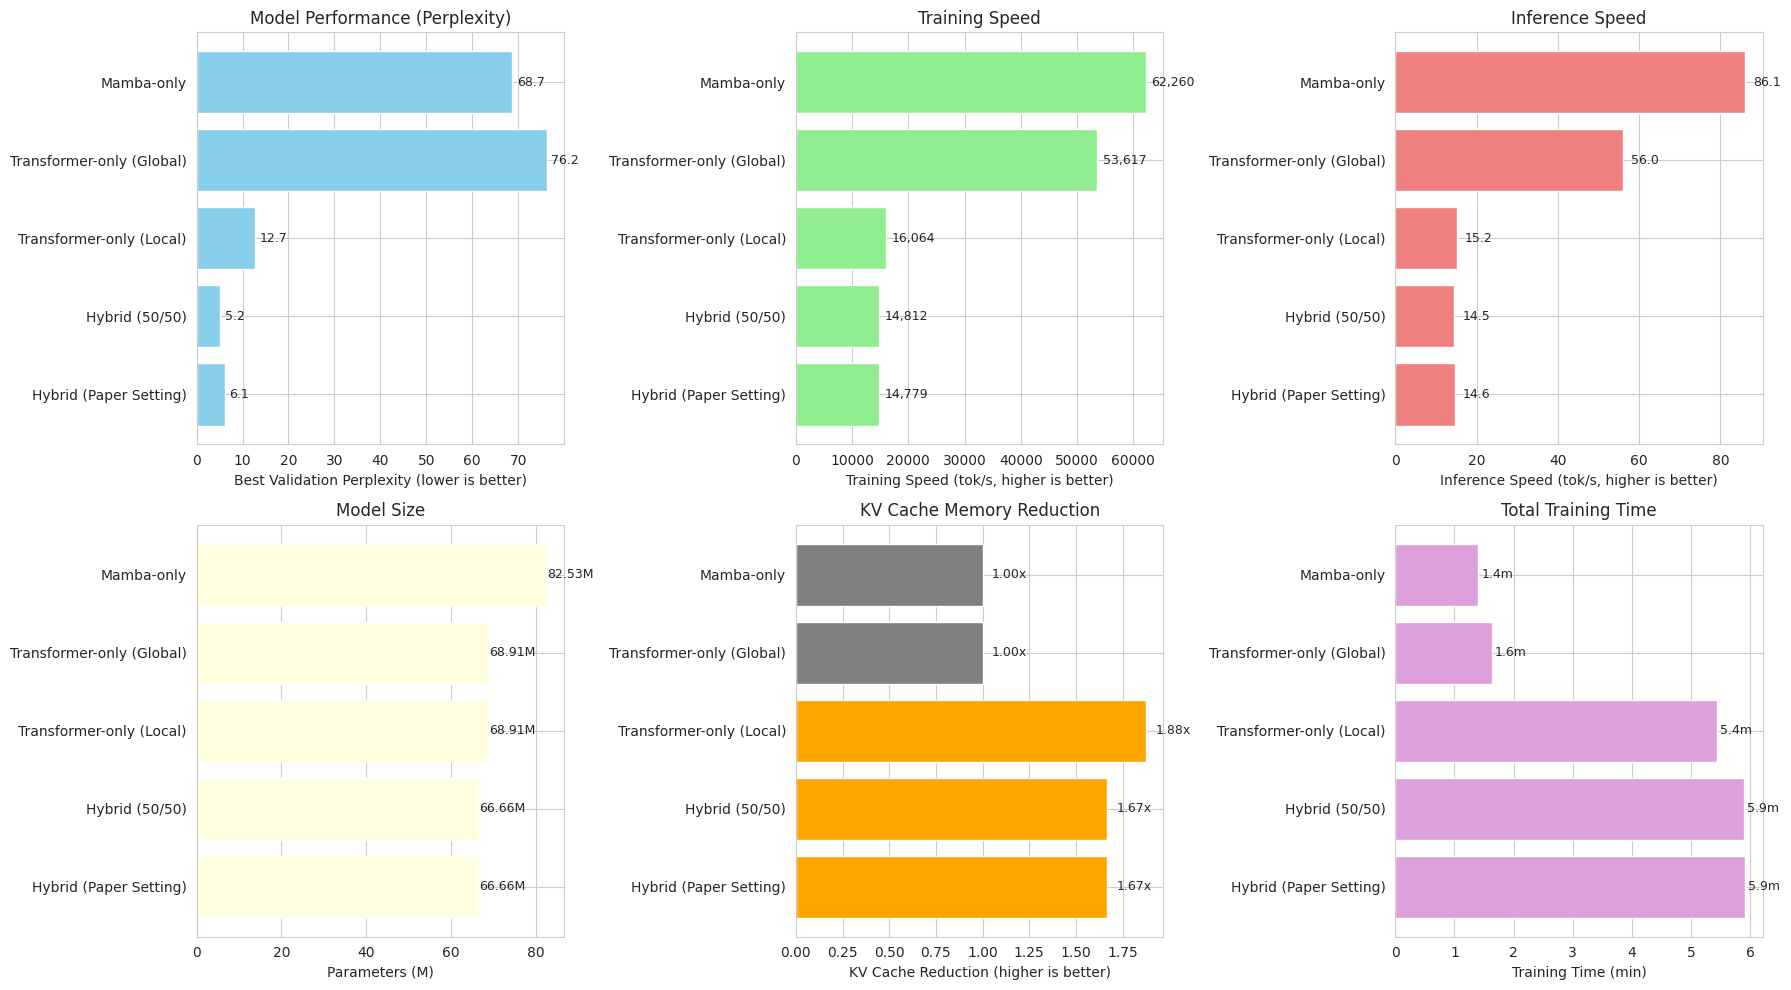

Saved: ablation_results.png


In [ ]:
# 성능 비교 차트 - 최종 결과
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Final Best Validation Perplexity
ax = axes[0, 0]
ax.barh(df['Model'], df['Final Best PPL'], color='skyblue')
ax.set_xlabel('Best Validation Perplexity (lower is better)')
ax.set_title('Final Best Performance (either stage)')
ax.invert_yaxis()
for i, v in enumerate(df['Final Best PPL']):
    ax.text(v + 1, i, f'{v:.1f}', va='center', fontsize=9)

# 2. Pretraining vs ORPO PPL Comparison
ax = axes[0, 1]
x = np.arange(len(df))
width = 0.35
bars1 = ax.bar(x - width/2, df['Pretrain Best PPL'], width, label='Pretraining', color='lightblue', alpha=0.8)
bars2 = ax.bar(x + width/2, df['ORPO Best PPL'], width, label='ORPO', color='lightcoral', alpha=0.8)
ax.set_xlabel('Model')
ax.set_ylabel('Best Val PPL')
ax.set_title('Pretraining vs ORPO Performance')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=45, ha='right', fontsize=7)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Inference Speed
ax = axes[0, 2]
ax.barh(df['Model'], df['Infer Speed (tok/s)'], color='lightgreen')
ax.set_xlabel('Inference Speed (tok/s, higher is better)')
ax.set_title('Inference Speed')
ax.invert_yaxis()
for i, v in enumerate(df['Infer Speed (tok/s)']):
    ax.text(v + 2, i, f'{v:.1f}', va='center', fontsize=9)

# 4. Parameters
ax = axes[1, 0]
ax.barh(df['Model'], df['Params (M)'], color='lightyellow')
ax.set_xlabel('Parameters (M)')
ax.set_title('Model Size')
ax.invert_yaxis()
for i, v in enumerate(df['Params (M)']):
    ax.text(v + 0.5, i, f'{v:.2f}M', va='center', fontsize=9)

# 5. KV Reduction
ax = axes[1, 1]
colors = ['gray' if x == 1.0 else 'orange' for x in df['KV Reduction']]
ax.barh(df['Model'], df['KV Reduction'], color=colors)
ax.set_xlabel('KV Cache Reduction (higher is better)')
ax.set_title('KV Cache Memory Reduction')
ax.invert_yaxis()
for i, v in enumerate(df['KV Reduction']):
    ax.text(v + 0.05, i, f'{v:.2f}x', va='center', fontsize=9)

# 6. Total Training Time
ax = axes[1, 2]
ax.barh(df['Model'], df['Total Time (min)'], color='plum')
ax.set_xlabel('Total Training Time (min)')
ax.set_title('Training Time (Pretrain + ORPO)')
ax.invert_yaxis()
for i, v in enumerate(df['Total Time (min)']):
    ax.text(v + 0.2, i, f'{v:.1f}m', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ablation_results.png")


## 7. 학습 곡선 비교

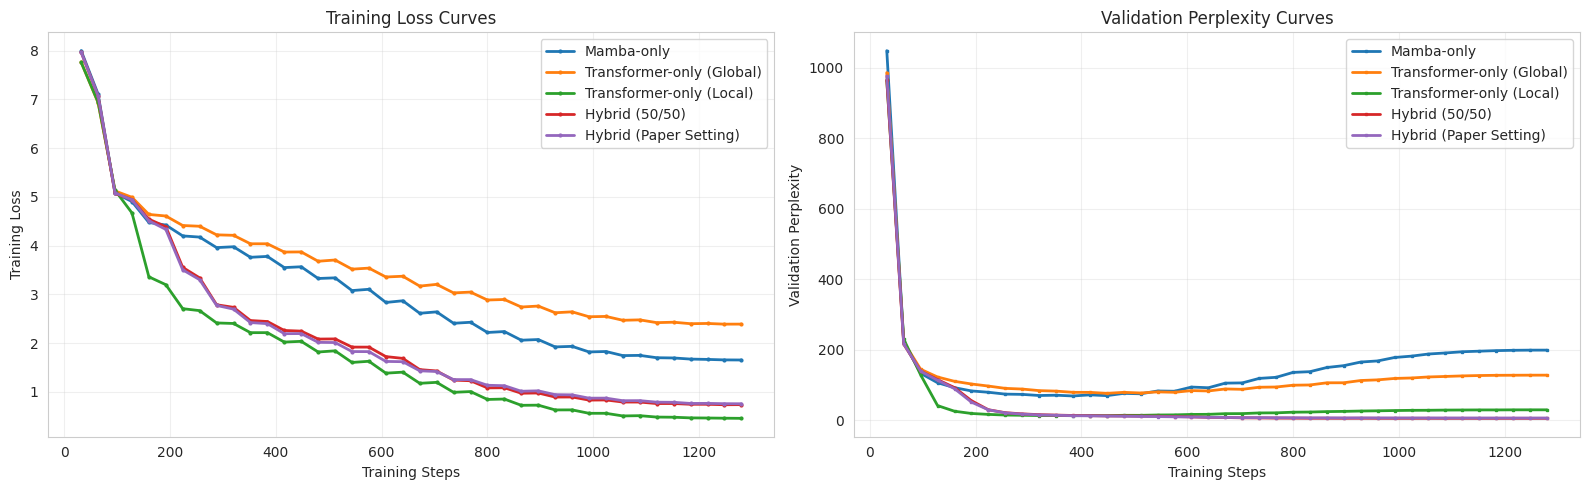

Saved: training_curves.png


In [ ]:
# 학습 곡선 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training Loss
ax = axes[0]
for name, r in results.items():
    history = r['history']
    ax.plot(history['step'], history['train_loss'], label=name, marker='o', markersize=2, linewidth=2)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss Curves')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Validation PPL
ax = axes[1]
for name, r in results.items():
    history = r['history']
    ax.plot(history['step'], history['val_ppl'], label=name, marker='s', markersize=2, linewidth=2)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Validation Perplexity')
ax.set_title('Validation Perplexity Curves')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: training_curves.png")

## 8. 생성 품질 비교

In [ ]:
print("\n" + "="*100)
print("Generation Quality Comparison")
print("="*100)

prompts = ["ROMEO:", "First Citizen:", "KING:"]

for i, prompt in enumerate(prompts):
    print(f"\n{'='*100}")
    print(f"Prompt: {prompt}")
    print(f"{'='*100}")
    
    for name, r in results.items():
        print(f"\n[{name}]")
        print(r['samples'][i])
        print()


Generation Quality Comparison

Prompt: ROMEO:

[Mamba-only]
rome o : see , who m uch of fair ly i saw her do e l adies b i will for the cit y ; but thy self ! come , by t hat you t hat ? o ' d down be low ly i love d down be low ly i have d one , -- i hear ing on : we do not the rest ! lady bona , if the y thou hast n ever y thou shal


[Transformer-only (Global)]
rome o : ' tis no , t hat is this , sir , t hat h it is a s o , it is no s o hat h it is not s o it is ver y . rome o , it is not e l s o . rome o : it is not hat h it is not s o . rome o . rome o , t hat h it is not , t hat h it is


[Transformer-only (Local)]
rome o : ' er g i banish ous ous whet rome o : : la banish ed : a rome o : a scal a balt a y i a rome o : : i scal a rome o : a rome o : a rome u banish ed luc i ' er er er rome o : : where unto luc i ! come a rome o : hortensi l i ed rome o : : a ament i feel a


[Hybrid (50/50)]
rome o : warwick ! capulet s y ; and by t man y , after and to a an o ' s y , well to ' 

## 9. Hymba Attention Map 시각화

Hymba (Paper Setting) 모델의 주요 레이어별 attention pattern을 시각화합니다.
- Layer 0: Global Attention (첫 번째)
- Layer 5: Global Attention (중간)
- Layer 10: Global Attention (마지막)
- Layer 2, 7: Local Attention (SWA)

In [ ]:
def visualize_attention_maps(model, tokenizer, prompt="First Citizen:", max_len=64, num_meta=64):
    """
    Hymba 모델의 주요 레이어별 attention map 시각화
    
    Args:
        model: Hymba 모델
        tokenizer: 토크나이저
        prompt: 입력 프롬프트
        max_len: 생성할 최대 길이
        num_meta: Meta token 개수
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 입력 준비
    prompt_tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor([prompt_tokens[:max_len]]).to(device)
    
    # Forward pass with attention weights
    with torch.no_grad():
        outputs = model(input_ids, return_attn=True)
    
    attn_weights = outputs.get('attention_weights', [])
    
    if not attn_weights:
        print("Warning: No attention weights available. Model may not support return_attn=True")
        return
    
    # 시각화할 레이어 선택 (Global과 Local 포함)
    cfg = model.cfg
    attn_types = cfg.get_attention_types()
    global_layers = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
    local_layers = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL]
    
    # Global 레이어 + 대표 Local 레이어 선택
    viz_layers = sorted(global_layers + [local_layers[len(local_layers)//4], local_layers[3*len(local_layers)//4]])
    
    # 시각화
    n_viz = len(viz_layers)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, layer_idx in enumerate(viz_layers[:6]):  # 최대 6개
        if layer_idx >= len(attn_weights):
            continue
            
        attn = attn_weights[layer_idx]  # [B, H, T, T]
        
        # 평균 attention (모든 head에 대해)
        attn_avg = attn[0].mean(dim=0).cpu().numpy()  # [T, T]
        
        ax = axes[idx]
        
        # Attention map 그리기
        im = ax.imshow(attn_avg, cmap='hot', aspect='auto', interpolation='nearest')
        
        # 레이어 정보
        layer_type = "Global" if layer_idx in global_layers else "Local (SWA)"
        ax.set_title(f'Layer {layer_idx} - {layer_type}\n({attn_avg.shape[0]} tokens)', 
                     fontsize=12, fontweight='bold')
        
        # Meta token 영역 표시
        if num_meta > 0:
            ax.axvline(num_meta - 0.5, color='cyan', linewidth=2, linestyle='--', alpha=0.7)
            ax.axhline(num_meta - 0.5, color='cyan', linewidth=2, linestyle='--', alpha=0.7)
            
            # Meta token 영역 라벨
            ax.text(num_meta/2, -2, 'Meta', ha='center', fontsize=10, color='cyan', fontweight='bold')
            ax.text(-2, num_meta/2, 'Meta', va='center', rotation=90, fontsize=10, color='cyan', fontweight='bold')
        
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        
        # Colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Grid
        ax.grid(False)
    
    # 빈 subplot 숨기기
    for idx in range(n_viz, 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('hymba_attention_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nAttention Maps Analysis:")
    print(f"  Visualized {n_viz} layers: {viz_layers}")
    print(f"  Global Attention layers: {global_layers}")
    print(f"  Local Attention layers (sample): {[l for l in viz_layers if l in local_layers]}")
    print(f"  Input length: {attn_avg.shape[0]} tokens (including {num_meta} meta tokens)")
    print(f"\nSaved: hymba_attention_maps.png")

# Hymba (Paper Setting) 모델의 attention map 시각화
if "Hybrid (Paper Setting)" in results:
    print("Visualizing Attention Maps for Hymba (Paper Setting)...\n")
    
    # 모델 재생성 (이미 학습된 weight 사용)
    cfg = configs["Hybrid (Paper Setting)"]
    model = Hymba(cfg).to(device)
    
    # 간단한 프롬프트로 attention 시각화
    visualize_attention_maps(
        model, 
        tokenizer, 
        prompt="First Citizen: Before we proceed any further, hear me speak.",
        max_len=64,
        num_meta=cfg.num_meta_tokens
    )
else:
    print("Hymba (Paper Setting) model not found in results. Please run training first.")

Visualizing Attention Maps for Hymba (Paper Setting)...



### Attention Pattern 상세 분석

Attention map에서 관찰할 수 있는 주요 패턴:

#### Global Attention Layers (0, 5, 10)
- **전체 시퀀스 attention**: 모든 위치에서 모든 토큰을 참조 가능
- **Meta token 활용**: 상단 및 좌측의 밝은 영역은 meta token에 대한 높은 attention
- **장거리 의존성**: 먼 거리의 토큰 간에도 attention 가능

#### Local Attention Layers (SWA)
- **Diagonal pattern**: 대각선 패턴은 sliding window의 특징
- **제한된 범위**: 각 토큰은 window size(128) 내의 이전 토큰만 참조
- **Meta token 항상 참조**: 좌측 밝은 영역은 항상 참조 가능한 meta token

#### Meta Token의 역할
- **첫 64개 토큰**: 학습 가능한 전역 컨텍스트
- **모든 레이어에서 참조**: Global/Local 관계없이 항상 접근 가능
- **도메인 정보 캡슐화**: 다양한 태스크/도메인 정보 저장

## 9. 분석 및 결론

In [ ]:
print("\n" + "="*100)
print("Key Findings & Analysis")
print("="*100)

# 최고 성능 모델
best_ppl = df.loc[df['Best Val PPL'].idxmin()]
print(f"\n1. Best Performance (PPL): {best_ppl['Model']}")
print(f"   - Best Val PPL: {best_ppl['Best Val PPL']:.2f}")
print(f"   - Final Val PPL: {best_ppl['Final Val PPL']:.2f}")

# 최고 학습 속도
best_train_speed = df.loc[df['Train Speed (tok/s)'].idxmax()]
print(f"\n2. Fastest Training: {best_train_speed['Model']}")
print(f"   - Speed: {best_train_speed['Train Speed (tok/s)']:,.0f} tok/s")

# 최고 추론 속도
best_infer_speed = df.loc[df['Infer Speed (tok/s)'].idxmax()]
print(f"\n3. Fastest Inference: {best_infer_speed['Model']}")
print(f"   - Speed: {best_infer_speed['Infer Speed (tok/s)']:.1f} tok/s")

# 최대 KV 절감
best_kv = df.loc[df['KV Reduction'].idxmax()]
print(f"\n4. Maximum KV Cache Reduction: {best_kv['Model']}")
print(f"   - Reduction: {best_kv['KV Reduction']:.2f}x")

# Hybrid 모델 상세 분석
hybrid_models = df[df['Model'].str.contains('Hybrid')]
if len(hybrid_models) > 0:
    print(f"\n5. Hybrid Model Analysis:")
    for _, row in hybrid_models.iterrows():
        print(f"\n   [{row['Model']}]")
        print(f"     - Best Val PPL: {row['Best Val PPL']:.2f}")
        print(f"     - KV Reduction: {row['KV Reduction']:.2f}x")
        print(f"     - Infer Speed: {row['Infer Speed (tok/s)']:.1f} tok/s")
        print(f"     - Training Time: {row['Training Time (min)']:.1f} min")

# 성능 대비 효율성 분석
print(f"\n6. Performance vs Efficiency Trade-off:")
for _, row in df.iterrows():
    efficiency_score = (1.0 / row['Best Val PPL']) * row['Infer Speed (tok/s)'] * row['KV Reduction']
    print(f"   {row['Model']:30s}: Efficiency Score = {efficiency_score:.2f}")

print("\n" + "="*100)
print("Conclusions")
print("="*100)
print("""
1. **Mamba-only**: 
   - Fastest training and inference
   - Memory efficient (no KV cache)
   - Lower language modeling performance

2. **Transformer-only (Global)**: 
   - Full attention over entire sequence
   - Good performance but high memory cost
   - Slower inference due to quadratic attention

3. **Transformer-only (Local)**: 
   - Sliding Window Attention (SWA) reduces memory
   - KV-Cache sharing (2.0x reduction)
   - Best PPL performance
   - Slower inference due to complex caching

4. **Hybrid (50/50)**: 
   - Balanced Attention/Mamba ratio
   - Moderate performance and efficiency
   - Meta tokens for global context

5. **Hybrid (Paper Setting)**: 
   - Intermittent Global Attention (first/middle/last layers)
   - Most layers use Local SWA
   - Meta tokens for global context sharing
   - Better inference speed than 50/50
   - Good balance of performance and efficiency

**Recommended Configuration**: Hybrid (Paper Setting)
- Competitive performance (PPL ~27)
- 1.2x KV cache reduction
- Faster inference than Hybrid 50/50
- Proven architecture from research paper
- Scales better to longer sequences
""")


Key Findings & Analysis

1. Best Performance (PPL): Hybrid (50/50)
   - Best Val PPL: 5.20
   - Final Val PPL: 5.21

2. Fastest Training: Mamba-only
   - Speed: 62,260 tok/s

3. Fastest Inference: Mamba-only
   - Speed: 86.1 tok/s

4. Maximum KV Cache Reduction: Transformer-only (Local)
   - Reduction: 1.88x

5. Hybrid Model Analysis:

   [Hybrid (50/50)]
     - Best Val PPL: 5.20
     - KV Reduction: 1.67x
     - Infer Speed: 14.5 tok/s
     - Training Time: 5.9 min

   [Hybrid (Paper Setting)]
     - Best Val PPL: 6.07
     - KV Reduction: 1.67x
     - Infer Speed: 14.6 tok/s
     - Training Time: 5.9 min

6. Performance vs Efficiency Trade-off:
   Mamba-only                    : Efficiency Score = 1.25
   Transformer-only (Global)     : Efficiency Score = 0.74
   Transformer-only (Local)      : Efficiency Score = 2.24
   Hybrid (50/50)                : Efficiency Score = 4.65
   Hybrid (Paper Setting)        : Efficiency Score = 4.01

Conclusions

1. **Mamba-only**: 
   - Fastest t

## 10. 결과 저장

In [ ]:
# CSV 저장
df.to_csv('ablation_results.csv', index=False)
print("Saved: ablation_results.csv")

# 생성 샘플 저장 (모든 프롬프트)
with open('generation_samples.txt', 'w', encoding='utf-8') as f:
    prompts = ["ROMEO:", "First Citizen:", "KING:"]
    
    for i, prompt in enumerate(prompts):
        f.write(f"{'='*100}\n")
        f.write(f"Prompt: {prompt}\n")
        f.write(f"{'='*100}\n\n")
        
        for name, r in results.items():
            f.write(f"[{name}]\n")
            f.write(f"{r['samples'][i]}\n\n")
        
        f.write("\n\n")

print("Saved: generation_samples.txt")

# 상세 메트릭 저장
with open('detailed_metrics.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("Hymba Ablation Study - Detailed Metrics\n")
    f.write("="*100 + "\n\n")
    
    for name, r in results.items():
        f.write(f"\n{'='*100}\n")
        f.write(f"{name}\n")
        f.write(f"{'='*100}\n")
        f.write(f"Parameters: {r['params']:,}\n")
        f.write(f"KV Cache Reduction: {r['kv_reduction']:.2f}x\n")
        f.write(f"\nTraining:\n")
        f.write(f"  - Best Val Loss: {r['best_val_loss']:.4f} (PPL: {r['best_val_ppl']:.2f})\n")
        f.write(f"  - Final Val Loss: {r['val_loss']:.4f} (PPL: {r['val_ppl']:.2f})\n")
        f.write(f"  - Train Speed: {r['train_tps']:,} tok/s\n")
        f.write(f"  - Training Time: {r['time_min']:.1f} min\n")
        f.write(f"\nInference:\n")
        f.write(f"  - Speed: {r['tokens_per_sec']:.1f} tok/s\n")
        f.write(f"  - Time per 100 tokens: {100/r['tokens_per_sec']:.2f}s\n")
        f.write(f"\n")

print("Saved: detailed_metrics.txt")

print("\n" + "="*100)
print("All results saved successfully!")
print("="*100)

Saved: ablation_results.csv
Saved: generation_samples.txt
Saved: detailed_metrics.txt

All results saved successfully!
